# Create TL from Green's functions
This code builds TL curves from seismic Green's functions for a range of sources and subsurface models

## Load Green's functions from pyrocko

In [1]:
%matplotlib notebook
import os

from pyrocko.gf import LocalEngine, Target, DCSource, ws
from pyrocko import trace
from pyrocko.gui.marker import PhaseMarker
from pyrocko import gf
from obspy.core.utcdatetime import UTCDateTime
import obspy 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyrocko import moment_tensor as pmt
from obspy.geodetics import kilometers2degrees
from scipy.interpolate import RectBivariateSpline

In [2]:
from scipy import signal
from tqdm import tqdm 

def filter_wave(waveform, f1, f2, dt):

    #b, a = signal.butter(N=10, Wn=[f1, f2], btype='bandpass', analog=False, fs=1./dt, output='ba')
    #y_tf = signal.lfilter(b, a, dirac)
    sos = signal.butter(N=10, Wn=[f1, f2], btype='bandpass', analog=False, fs=1./dt, output='sos')
    return signal.sosfilt(sos, waveform)

def show_bounds(store):

    # Get the spatial bounds for receivers
    distance_min = store.config.distance_min
    distance_max = store.config.distance_max

    # Get the spatial bounds for sources
    depth_min = store.config.source_depth_min
    depth_max = store.config.source_depth_max

    # Print the bounds
    print(f"Receiver distance range: {distance_min} km to {distance_max} km")
    print(f"Source depth range: {depth_min} km to {depth_max} km")

def prepare_mts(strikes):
    
    scalar_moment = 10e6
    strike, dip, rake = 0., 90., 180.
    mt_strike = pmt.MomentTensor(strike=strike, dip=dip, rake=rake, scalar_moment=scalar_moment).m6()
    strike, dip, rake = 0., 90., 270.
    mt_normal = pmt.MomentTensor(strike=strike, dip=dip, rake=rake, scalar_moment=scalar_moment).m6()
    
    types = []
    mts = []
    for strike in strikes:
        types += ['strike_slip', 'normal']
        mts.append( dict(mnn=mt_strike[0]+strike, mee=mt_strike[1], mdd=mt_strike[2], mne=mt_strike[3], mnd=mt_strike[4], med=mt_strike[5],) )
        mts.append( dict(mnn=mt_normal[0]+strike, mee=mt_normal[1], mdd=mt_normal[2], mne=mt_normal[3], mnd=mt_normal[4], med=mt_normal[5]) )
        
    return types, mts
    
def prepare_waveforms(dist, azimuths, ref_location):
    
    azimuths_rad = np.radians(azimuths)
    id_dist, id_azimuths = np.arange(dist.size), np.arange(len(azimuths))
    id_dist, id_azimuths = np.meshgrid(id_dist, id_azimuths)
    id_dist, id_azimuths = id_dist.ravel(), id_azimuths.ravel()
    north_shifts = dist[id_dist] * np.cos(azimuths_rad[id_azimuths])
    east_shifts = dist[id_dist] * np.sin(azimuths_rad[id_azimuths])
    
    waveform_targets = [
        gf.Target(
            quantity='velocity',
            lat = ref_location[0],
            lon = ref_location[1],
            north_shift=north_shift,
            east_shift=east_shift,
            store_id=store_id,
            interpolation='multilinear',
            codes=('NET', 'STA', 'LOC', 'Z'))
        for north_shift, east_shift in tqdm(zip(north_shifts, east_shifts), total=east_shifts.size)
        ]
    
    return waveform_targets, dist[id_dist], azimuths_rad[id_azimuths]
    
def build_amps_and_traces(dists, depths, base_folder, store_id, f_targets, stf=None):

    engine = gf.LocalEngine(store_dirs=[f'{base_folder}{store_id}/'])
    store = engine.get_store(store_id)
    show_bounds(store)
    
    ref_location = [0., 0.]
    
    delta_az = 25.
    azimuths = np.arange(0., 360., delta_az)
    #azimuths = [0.]
    waveform_targets, dists_waveform, az_waveform = prepare_waveforms(dists, azimuths, ref_location)
    
    strikes = [0.]
    types, mts = prepare_mts(strikes)
    
    id_mts, id_depths = np.meshgrid(np.arange(len(mts)), np.arange(len(depths)))
    id_mts, id_depths = np.meshgrid(id_mts, id_depths)
    id_mts, id_depths = id_mts.ravel(), id_depths.ravel()
    
    all_amps_RW = pd.DataFrame()
    all_amps_S = pd.DataFrame()
    factor = 1.
    for id_mt, id_depth in tqdm(zip(id_mts, id_depths), total=id_depths.size):
        
        mt = mts[id_mt]
        depth = depths[id_depth]
        type_mt = types[id_mt]

        stf_add = {}
        if stf is not None:
            stf_add['stf'] = stf
        mt_source = gf.MTSource(lat=ref_location[0], lon=ref_location[1], depth=depth, **mt, **stf_add)

        # The computation is performed by calling process on the engine
        try:
            response = engine.process(mt_source, waveform_targets)
        except:
            dict_RW = pd.DataFrame(np.c_[-np.ones_like(dists_waveform), -np.ones_like(dists_waveform), dists_waveform, az_waveform], columns=['amp_RW', 'amp_S', 'dist', 'az'])
            dict_RW['type_mt'] = type_mt
            dict_RW['depth'] = depth
            all_amps_RW = pd.concat([all_amps_RW, dict_RW])

            dict_RW = pd.DataFrame(np.c_[-np.ones_like(dists_waveform), -np.ones_like(dists_waveform), dists_waveform, az_waveform], columns=['amp_RW', 'amp_S', 'dist', 'az'])
            dict_RW['type_mt'] = type_mt
            dict_RW['depth'] = depth
            all_amps_RW = pd.concat([all_amps_RW, dict_RW])
            
        # convert results in response to Pyrocko traces
        synthetic_traces = response.pyrocko_traces()

        amps_RW = []
        amps_S = []
        for t, waveform in zip(waveform_targets, synthetic_traces):
            dist = t.distance_to(mt_source)
            depth = mt_source.depth
            #print(dist, depth)
            t_s = store.t('s', (depth, dist))
            t_S = store.t('S', (depth, dist))
            arrival_time = t_s
            if (t_s is None):
                arrival_time = t_S
            elif t_S is not None:
                arrival_time = min(t_S, t_s)
            if (t_S is None):
                arrival_time = t_s

            if arrival_time is None:
                v_RW = (1./0.95)*dist/waveform.get_xdata()[waveform.get_ydata().argmax()]
                t_RW = dist/v_RW
                arrival_time = t_RW-20.
            else:
                arrival_time += 10.

            dt = waveform.get_xdata()[1]-waveform.get_xdata()[0]
            waveform_processed = waveform.get_ydata()
            if f_targets:
                waveform_processed = filter_wave(waveform_processed, f_targets[0], f_targets[1], dt)

            max_RW = abs(waveform_processed).max()
            amps_RW.append(max_RW)
            iS = np.argmin(abs(waveform.get_xdata()-(arrival_time)))
            max_S = abs(waveform_processed)[:iS].max()
            amps_S.append(max_S)
            
        dict_RW = pd.DataFrame(np.c_[amps_RW, amps_S, dists_waveform, az_waveform], columns=['amp_RW', 'amp_S', 'dist', 'az'])
        dict_RW['type_mt'] = type_mt
        dict_RW['depth'] = depth
        dict_RW['depth'] = depth
        all_amps_RW = pd.concat([all_amps_RW, dict_RW])
        
        dict_RW = pd.DataFrame(np.c_[amps_RW, amps_S, dists_waveform, az_waveform], columns=['amp_RW', 'amp_S', 'dist', 'az'])
        dict_RW['type_mt'] = type_mt
        dict_RW['depth'] = depth
        all_amps_RW = pd.concat([all_amps_RW, dict_RW])
    
    return all_amps_RW, all_amps_S

## Discretization
delta_dist = 50e3
epsilon = 5e3
dists = []
#dists.append(np.arange(0., 50.e3, 5e3)) # in km
dists.append(np.arange(50.e3+epsilon, 8000.e3+epsilon, delta_dist)) # in km
dists.append(np.arange(8000.e3+epsilon, 16000.e3+epsilon, delta_dist)) # in km
#dists.append(np.arange(0., 50.e3, 5e3)) # in km
#dists.append(np.arange(50.e3+epsilon, 8000.e3+epsilon, delta_dist)) # in km
#dists.append(np.arange(8000.e3+epsilon, 16000.e3+epsilon, delta_dist)) # in km
delta_depth = 5e3
depths = np.arange(5e3, 50e3+delta_depth, delta_depth)

## STF
period = 1.
stf = gf.BoxcarSTF(period, anchor=0.)
stf = None

f_targets = [0.001, 0.025]

## Greens functions STORES
base_folder = '/projects/infrasound/data/infrasound/2023_Venus_inversion/'
stores_id = []
#stores_id.append('GF_venus_qssp_nearfield')
stores_id.append('GF_venus_qssp')
stores_id.append('GF_venus_qssp_8000km')
#stores_id.append('GF_venus_qssp_nearfield_c50km')
#stores_id.append('GF_venus_qssp_c50km')
#stores_id.append('GF_venus_qssp_8000km_c50km')

all_amps_RW, all_amps_S = pd.DataFrame(), pd.DataFrame()
for istore, (store_id, dist) in enumerate(zip(stores_id, dists)):
    all_amps_RW_loc, all_amps_S_loc = build_amps_and_traces(dist, depths, base_folder, store_id, f_targets, stf=None)
    all_amps_RW_loc['store'] = store_id
    all_amps_S_loc['store'] = store_id
    
    all_amps_RW = pd.concat([all_amps_RW, all_amps_RW_loc])
    all_amps_S = pd.concat([all_amps_S, all_amps_S_loc])

StoreError: directory "C:\projects\infrasound\data\infrasound\2023_Venus_inversion\GF_venus_qssp" does not seem to contain a GF store ("config" file not found)

In [ ]:
import sys
sys.path.append('/staff/quentin/Documents/Projects/2024_Venus_Detectability/')
import compute_TL_modules_ as ctm
from importlib import reload
reload(ctm)

## Discretization
delta_dist = 50e3
epsilon = 5e3
dists = []
dists.append(np.arange(0., 50.e3, 5e3)) # in km
#dists.append(np.arange(50.e3+epsilon, 8000.e3+epsilon, delta_dist)) # in km
#dists.append(np.arange(8000.e3+epsilon, 16000.e3+epsilon, delta_dist)) # in km
#dists.append(np.arange(0., 50.e3, 5e3)) # in km
#dists.append(np.arange(50.e3+epsilon, 8000.e3+epsilon, delta_dist)) # in km
#dists.append(np.arange(8000.e3+epsilon, 16000.e3+epsilon, delta_dist)) # in km
delta_depth = 5e3
delta_depth = 25e3
depths = np.arange(5e3, 50e3+delta_depth, delta_depth)

## STF
period = 1./1e-1
stf = gf.BoxcarSTF(period, anchor=0.)
stf = gf.BoxcarSTF(period, anchor=0.)
stf = gf.TriangularSTF(effective_duration=period)
stf = None

bins = np.logspace(np.log10(1e-2), np.log10(0.5), 4)
f_targets = []
for ibin, (binleft, binright) in enumerate(zip(bins[:-1], bins[1:])):
    if ibin == 0:
        binleft = None
    if ibin == len(bins)-2:
        binright = None
    f_targets += [[binleft, binright]]
print(f_targets)

## Greens functions STORES
base_folder = '/projects/infrasound/data/infrasound/2023_Venus_inversion/'
stores_id = []

stores_id.append('GF_venus_qssp_nearfield')
#stores_id.append('GF_venus_qssp')
#stores_id.append('GF_venus_qssp_8000km')

#stores_id.append('GF_venus_qssp_nearfield_c50km')
#stores_id.append('GF_venus_qssp_c50km')
#stores_id.append('GF_venus_qssp_8000km_c50km')

all_amps_RW = ctm.get_all_amps(base_folder, stores_id, dists, depths, f_targets, stf)

In [65]:
all_amps_RW_nearfield = pd.read_csv('./data/GF_Dirac_1Hz_nearfield.csv', header=[0])
all_amps_RW_c50km = pd.read_csv('./data/GF_Dirac_1Hz_c50km.csv', header=[0])

<IPython.core.display.Javascript object>


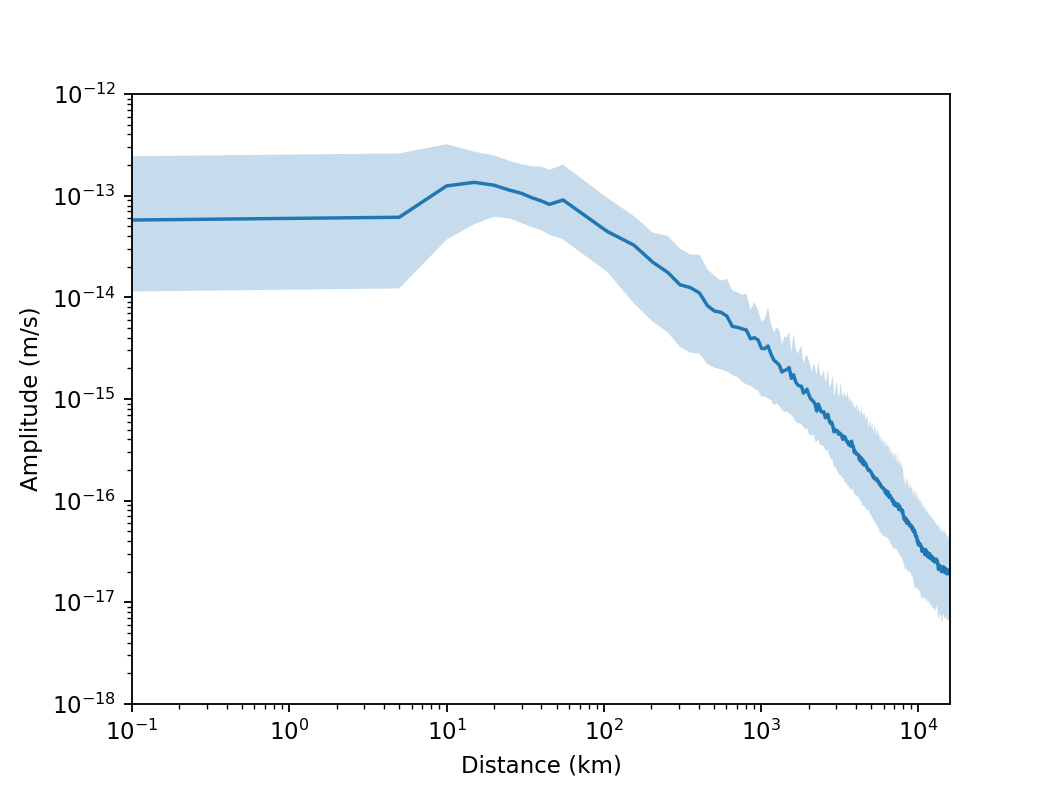

In [73]:
plt.figure()

all_amps = pd.concat([all_amps_RW_nearfield, all_amps_RW, all_amps_RW_c50km])

#for store, group in all_amps.groupby('store'):
group = all_amps.loc[all_amps.amp_RW>0]
median = group.groupby(['dist']).median().reset_index().amp_RW.values
q25 = group.groupby(['dist']).quantile(q=0.25).reset_index().amp_RW.values
q75 = group.groupby(['dist']).quantile(q=0.75).reset_index().amp_RW.values
dists = group.dist.unique()

plt.plot(dists/1e3, median, label=store)
plt.fill_between(dists/1e3, q25, q75, alpha=0.25,)
    
#plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e2/1e3, group.dist.max()/1e3])
plt.ylim([1e-18, 1e-12])
plt.xlabel('Distance (km)')
plt.ylabel('Amplitude (m/s)')

plt.savefig('./figures/TL.png')

In [74]:
group.to_csv('./data/GF_Dirac_1Hz_all.csv', header=True, index=False)

In [52]:
all_amps_RW.to_csv('./data/GF_Dirac_1Hz_c15km.csv', header=True, index=False)

## Visualization of Green's functions

In [24]:
import seaborn as sns
colors = sns.color_palette("husl", len(waveform_targets_all))

plt.figure()
plot_arrivals = False
istore = -1
for waveform_targets, synthetic_traces in zip(waveform_targets_all, synthetic_traces_all):
    iwaveform = -1
    istore += 1
    for t, waveform in zip(waveform_targets, synthetic_traces):
        iwaveform += 1
        plt.plot(waveform.get_xdata(), waveform.get_ydata()/waveform.get_ydata().max()+iwaveform, zorder=1, color=colors[istore])

        if plot_arrivals:
            dist = t.distance_to(mt_source)
            depth = mt_source.depth
            #print(dist, depth)
            arrival_time_P = store.t('P', (depth, dist))-10.
            arrival_time_P_end = arrival_time_P+20.
            arrival_time_S = store.t('S', (depth, dist))-10.
            arrival_time_S_end = arrival_time_S+20.
            it = np.argmin(abs(waveform.get_xdata()-arrival_time_P))
            plt.scatter(waveform.get_xdata()[it], iwaveform, marker='|', color='black', s=50, zorder=10)
            it = np.argmin(abs(waveform.get_xdata()-arrival_time_P_end))
            plt.scatter(waveform.get_xdata()[it], iwaveform, marker='|', color='black', s=50, zorder=10)
            it = np.argmin(abs(waveform.get_xdata()-arrival_time_S))
            plt.scatter(waveform.get_xdata()[it], iwaveform, marker='|', color='black', s=50, zorder=10)
            it = np.argmin(abs(waveform.get_xdata()-arrival_time_S_end))
            plt.scatter(waveform.get_xdata()[it], iwaveform, marker='|', color='black', s=50, zorder=10)
            
plt.figure()
istore = -1
for all_amps_RW, all_amps_S in zip(all_amps_RW_all, all_amps_S_all):
    istore += 1
    plt.plot(all_amps_RW.T, color=colors[istore])

KeyboardInterrupt: 

## Extraction of median/quantiles, extrapolation to global scale (>10000 km), writes to file

<IPython.core.display.Javascript object>


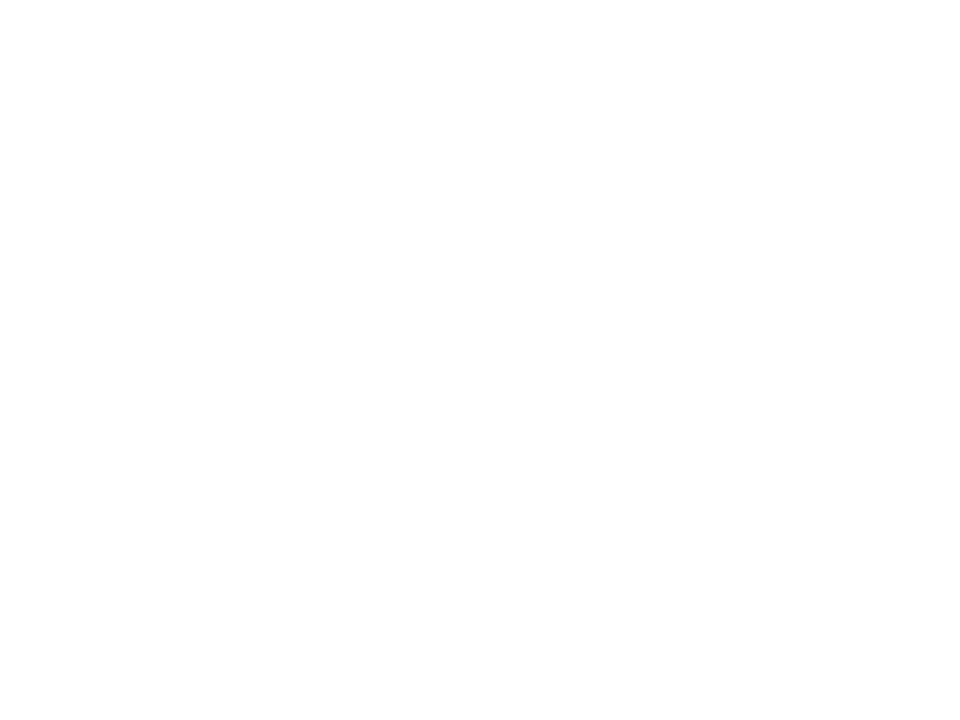

In [38]:
from scipy import interpolate, stats
from scipy.optimize import curve_fit

def fit_TL_global(x, a, b, c):
    return a * np.exp(-b * x) + c
    
def get_git_params(dists, amps, factor, dist_lim, bounds=[0.1, 0.1, 1e2]):
    
    #factor = 1e20
    #dist_lim = 30
    popt, pcov = curve_fit(fit_TL_global, dists[dists>dist_lim], factor*amps[dists>dist_lim], bounds=(0, bounds))
    return popt
    
def construct_one_TL_global(dists, amps, factor, dist_lim):
    
    f = interpolate.interp1d(dists, amps, bounds_error=False, fill_value=(amps[0], amps[-1]))
    #popt = get_git_params(dists, amps, factor, dist_lim, bounds=[0.1, 0.1, 1e2])
    #f_global = lambda dist: fit_TL_global(dist, *popt)/factor
    #dist_max = dists.max()
    #TL_q = lambda dist: np.where(dist<dist_max, f(dist), f_global(dist))
    TL_q = lambda dist: f(dist)
    return TL_q

def build_median_qmin_qmax(dists, all_amps_RW, all_amps_S, qs=[0.25, 0.75], dist_lim=30., dist_lim_body=49., factor=1e20):

    #dists = np.arange(1., 80., 1)[:] # in degrees
    amps = np.median(all_amps_RW, axis=0)
    f_median = construct_one_TL_global(dists, amps, factor, dist_lim)
    f_qs = []
    for q in qs:
        amps = np.quantile(all_amps_RW, q=q, axis=0)
        f_qs.append( construct_one_TL_global(dists, amps, factor, dist_lim) )
    
    amps = np.median(all_amps_S, axis=0)
    f_median_body = construct_one_TL_global(dists, amps, factor, dist_lim_body)
    f_qs_body = []
    for q in qs:
        amps = np.quantile(all_amps_S, q=q, axis=0)
        f_qs_body.append( construct_one_TL_global(dists, amps, factor, dist_lim_body) )
    
    return f_median, f_qs, f_median_body, f_qs_body

def write_tofile(file, dists_new, f_median, f_qs, f_median_body, f_qs_body, qs):
    array = np.c_[dists_new, 
                  f_median(dists_new),
                  f_qs[0](dists_new),
                  f_qs[1](dists_new), 
                  f_median_body(dists_new),
                  f_qs_body[0](dists_new),
                  f_qs_body[1](dists_new), ]
    columns = ['dist',
               'median_rw',
               f'median_q{qs[0]}_rw',
               f'median_q{qs[1]}_rw',
               'median_body',
               f'median_q{qs[0]}_body',
               f'median_q{qs[1]}_body',]
    TLs = pd.DataFrame(array, columns=columns)
    TLs.to_csv(file, header=True, index=False)
    return TLs
    
dist_lim=50.
dist_lim_body=50.
factor=1e20
#dists_new = np.linspace(0.1, 180., 200)
dists_new = np.linspace(dists_all.min(), dists_all.max(), 200)
qs=[0.25, 0.75]
file = './data/GF_Dirac_1Hz.csv'
f_median, f_qs, f_median_body, f_qs_body = build_median_qmin_qmax(dists_all, all_amps_RW_all, all_amps_S_all, qs=qs, dist_lim=dist_lim, dist_lim_body=dist_lim_body, factor=factor)

TLs = write_tofile(file, dists_new, f_median, f_qs, f_median_body, f_qs_body, qs)
    
plt.figure()
plt.plot(dists_new, f_median(dists_new), color='tab:blue', zorder=10, label='Rayleigh wave')
plt.fill_between(dists_new, f_qs[0](dists_new), f_qs[1](dists_new), color='tab:blue', alpha=0.3, zorder=10)
plt.plot(dists_new, f_median_body(dists_new), color='tab:red', zorder=10, label='Body wave')
plt.fill_between(dists_new, f_qs_body[0](dists_new), f_qs_body[1](dists_new), color='tab:red', alpha=0.3, zorder=10)

plt.xlabel('Distance (degrees)')
plt.ylabel('Vertical velocity (m/s)')
plt.yscale('log')
plt.legend()
#plt.ylim([factor*1e-24, factor*1e-19])